# 🧬 Cancer Risk Classification — A Pipeline Journey  

**TL;DR:** Building a transparent and reproducible ML pipeline to classify cancer types from patient-level risk factors — with rigorous leakage checks and interpretable insights.  

---

## Overview  

Cancer risk prediction sits at the intersection of **medicine, statistics, and machine learning**.  
Each patient’s profile — lifestyle choices, genetic predispositions, and clinical indicators — encodes subtle signals that can help identify cancer types or risk tiers.  

This notebook demonstrates a **complete, end-to-end ML workflow**, showing how to explore, clean, and model healthcare-style tabular data responsibly.  
The focus extends beyond raw accuracy — toward **trustworthy, interpretable models** that provide meaningful insights while preventing data leakage and bias.  

---

## The Pipeline  

- **Exploration:** Visualize feature distributions, correlations, and class balance to understand the data landscape.  
- **Leakage Detection:** Confirm whether `Risk_Level` is derived from `Overall_Risk_Score` to ensure fair learning.  
- **Preprocessing:** Build robust pipelines with `ColumnTransformer`, combining imputation, scaling, and one-hot encoding.  
- **Modeling:** Compare algorithms — Logistic Regression, Random Forest, Calibrated SVM, and XGBoost — using **macro-F1** for balanced performance evaluation.  
- **Interpretability:** Use confusion matrices and permutation importance for transparent, human-readable explanations.  


## Environment / Versions

In [1]:
import sys, warnings
warnings.filterwarnings("ignore")

# Optional import (some environments lack xgboost)
try:
    import xgboost
except ImportError:
    xgboost = None

# Core libraries
import numpy, pandas, seaborn, matplotlib, sklearn

print("✅ Environment Versions")
print("-----------------------")
print("Python:", sys.version.split()[0])
print("sklearn:", sklearn.__version__)
print("xgboost:", getattr(xgboost, "__version__", "N/A"))
print("seaborn:", seaborn.__version__)
print("matplotlib:", matplotlib.__version__)
print("numpy:", numpy.__version__)
print("pandas:", pandas.__version__)


✅ Environment Versions
-----------------------
Python: 3.11.13
sklearn: 1.2.2
xgboost: 2.0.3
seaborn: 0.12.2
matplotlib: 3.7.2
numpy: 1.26.4
pandas: 2.2.3


## Config / Flags

In [2]:
RANDOM_STATE = 42
FAST_MODE = True           # reduce heavy steps (estimators, pairwise plots)
MAX_ROWS_FOR_PLOTS = 2000  # cap rows for heavy plots
DISABLE_PAIRPLOT = True    # set False to enable pairplot
VERBOSE = True

def info(msg):
    if VERBOSE:
        print(f"[INFO] {msg}")


## Imports & Setup Data

In [3]:
import random, os , inspect
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer

# Optional: XGBoost (fallback-safe)
try:
    from xgboost import XGBClassifier
    HAVE_XGB = True
except ImportError:
    HAVE_XGB = False

# Plot style
plt.rcParams.update({
    "figure.figsize": (8, 5),
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.grid": True,
})
sns.set_theme(style="ticks", context="notebook")

# Reproducibility
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
warnings.filterwarnings("ignore")


## Load Data 

In [4]:
local_path = "cancer-risk-factors.csv"
kaggle_path = "/kaggle/input/cancer-risk-factors-dataset/cancer-risk-factors.csv"

DATA_PATH = local_path if os.path.exists(local_path) else kaggle_path
print(f"📂 Using data from: {DATA_PATH}")

df = pd.read_csv(DATA_PATH)
print("✅ Loaded successfully!")
print("Shape:", df.shape)
display(df.head())

print("\nDtypes:"); print(df.dtypes)
print("\nNulls per column:"); print(df.isna().sum())
print("\nDuplicate rows:", int(df.duplicated().sum()))

if "Patient_ID" in df.columns:
    print("\nPatient_ID unique:", df["Patient_ID"].is_unique)

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in df.columns if c not in num_cols]

display(df[num_cols].describe().T)


📂 Using data from: /kaggle/input/cancer-risk-factors-dataset/cancer-risk-factors.csv
✅ Loaded successfully!
Shape: (2000, 21)


,Patient_ID,Cancer_Type,Age,Gender,Smoking,Alcohol_Use,Obesity,Family_History,Diet_Red_Meat,Diet_Salted_Processed,...,Physical_Activity,Air_Pollution,Occupational_Hazards,BRCA_Mutation,H_Pylori_Infection,Calcium_Intake,Overall_Risk_Score,BMI,Physical_Activity_Level,Risk_Level
0,LU0000,Breast,68,0,7,2,8,0,5,3,...,4,6,3,1,0,0,0.398696,28.0,5,Medium
1,LU0001,Prostate,74,1,8,9,8,0,0,3,...,1,3,3,0,0,5,0.424299,25.4,9,Medium
2,LU0002,Skin,55,1,7,10,7,0,3,3,...,1,8,10,0,0,6,0.605082,28.6,2,Medium
3,LU0003,Colon,61,0,6,2,2,0,6,2,...,6,4,8,0,0,8,0.318449,32.1,7,Low
4,LU0004,Lung,67,1,10,7,4,0,6,3,...,9,10,9,0,0,5,0.524358,25.1,2,Medium



Dtypes:
Patient_ID                  object
Cancer_Type                 object
Age                          int64
Gender                       int64
Smoking                      int64
Alcohol_Use                  int64
Obesity                      int64
Family_History               int64
Diet_Red_Meat                int64
Diet_Salted_Processed        int64
Fruit_Veg_Intake             int64
Physical_Activity            int64
Air_Pollution                int64
Occupational_Hazards         int64
BRCA_Mutation                int64
H_Pylori_Infection           int64
Calcium_Intake               int64
Overall_Risk_Score         float64
BMI                        float64
Physical_Activity_Level      int64
Risk_Level                  object
dtype: object

Nulls per column:
Patient_ID                 0
Cancer_Type                0
Age                        0
Gender                     0
Smoking                    0
Alcohol_Use                0
Obesity                    0
Family_History      

,count,mean,std,min,25%,50%,75%,max
Age,2000.0,63.248000,10.462946,25.000000,56.000000,64.000000,70.000000,90.000000
Gender,2000.0,0.489000,0.500004,0.000000,0.000000,0.000000,1.000000,1.000000
Smoking,2000.0,5.157000,3.325339,0.000000,2.000000,5.000000,8.000000,10.000000
Alcohol_Use,2000.0,5.035000,3.260996,0.000000,2.000000,5.000000,8.000000,10.000000
Obesity,2000.0,5.967500,3.061393,0.000000,4.000000,6.000000,9.000000,10.000000
Family_History,2000.0,0.194500,0.395914,0.000000,0.000000,0.000000,0.000000,1.000000
Diet_Red_Meat,2000.0,5.189500,3.154452,0.000000,3.000000,5.000000,8.000000,10.000000
Diet_Salted_Processed,2000.0,4.563500,3.088323,0.000000,2.000000,4.000000,7.000000,10.000000
Fruit_Veg_Intake,2000.0,4.927500,3.045305,0.000000,3.000000,5.000000,8.000000,10.000000
Physical_Activity,2000.0,4.015000,2.978458,0.000000,1.000000,4.000000,6.000000,10.000000


## 🧾 Data Dictionary  

| Feature | Description |
|----------|-------------|
| **Age** | Patient age in years |
| **BMI** | Body Mass Index (weight/height ratio) |
| **Smoking, Alcohol_Use, Obesity** | Lifestyle flags (Yes/No) |
| **Family_History, BRCA_Mutation, H_Pylori_Infection** | Clinical/genetic risk indicators |
| **Overall_Risk_Score** | Combined numeric risk score  |
| **Risk_Level** | Derived categorical tier (Low / Medium / High) |
| **Cancer_Type** | Target label — multiclass cancer category |
| **Patient_ID** | Unique identifier (dropped before modeling) |


# Leakage Probe — Risk_Level vs Overall_Risk_Score
### We check whether `Risk_Level` is a direct mapping of `Overall_Risk_Score` (leakage risk).

In [5]:
assert "Cancer_Type" in df.columns, "Cancer_Type column is required"
assert "Risk_Level" in df.columns, "Risk_Level column is required"
assert "Overall_Risk_Score" in df.columns, "Overall_Risk_Score column is required"

print("Target candidates:")
print(" - Cancer_Type (unique classes):", df["Cancer_Type"].nunique())
print(" - Risk_Level (unique classes):", df["Risk_Level"].unique())

ranges = df.groupby("Risk_Level")["Overall_Risk_Score"].agg(["min", "max", "nunique"])
display(ranges)

score_map_unique = df.groupby("Overall_Risk_Score")["Risk_Level"].nunique().le(1).all()
print(f"Is each Overall_Risk_Score mapped to a unique Risk_Level? → {score_map_unique}")

# Drop identifier (safety)
if "Patient_ID" in df.columns:
    df = df.drop(columns=["Patient_ID"])
    print("Dropped identifier column: Patient_ID")
    
# Define potential leakage columns
LEAKY_COLS = ["Risk_Level", "Overall_Risk_Score"]
print(f"Will exclude at modeling time (to avoid leakage): {LEAKY_COLS}")


Target candidates:
 - Cancer_Type (unique classes): 5
 - Risk_Level (unique classes): ['Medium' 'Low' 'High']


,min,max,nunique
Risk_Level,,,
High,0.660797,0.852158,102
Low,0.029285,0.329922,324
Medium,0.330033,0.659130,1574


Is each Overall_Risk_Score mapped to a unique Risk_Level? → True
Dropped identifier column: Patient_ID
Will exclude at modeling time (to avoid leakage): ['Risk_Level', 'Overall_Risk_Score']


## Exploratory Data Analysis (EDA)

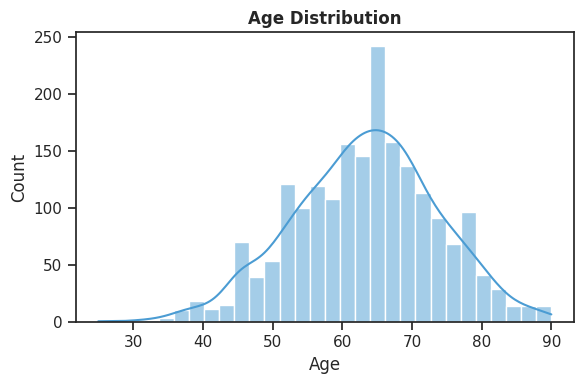

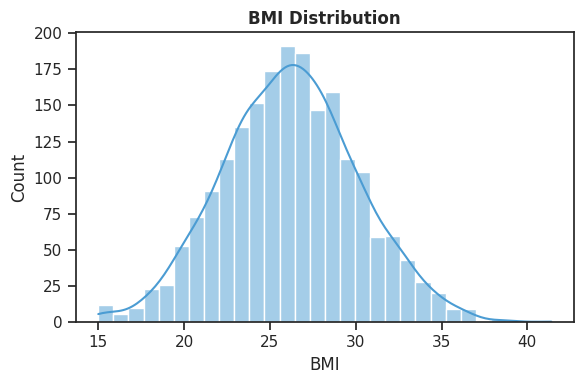

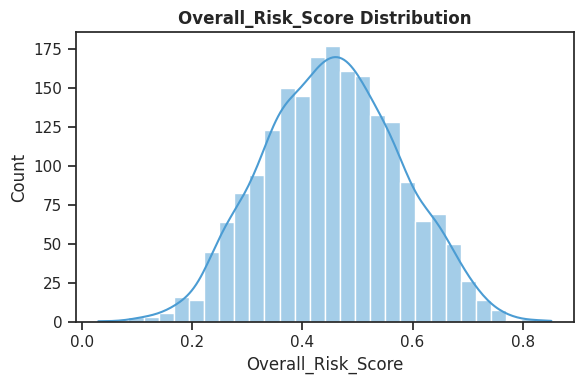

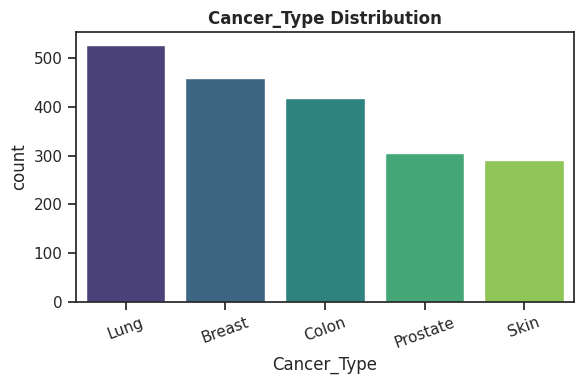

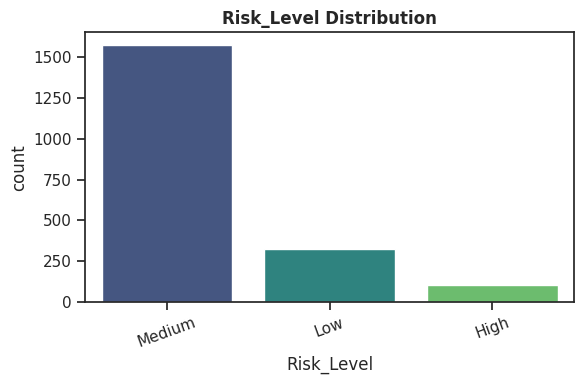

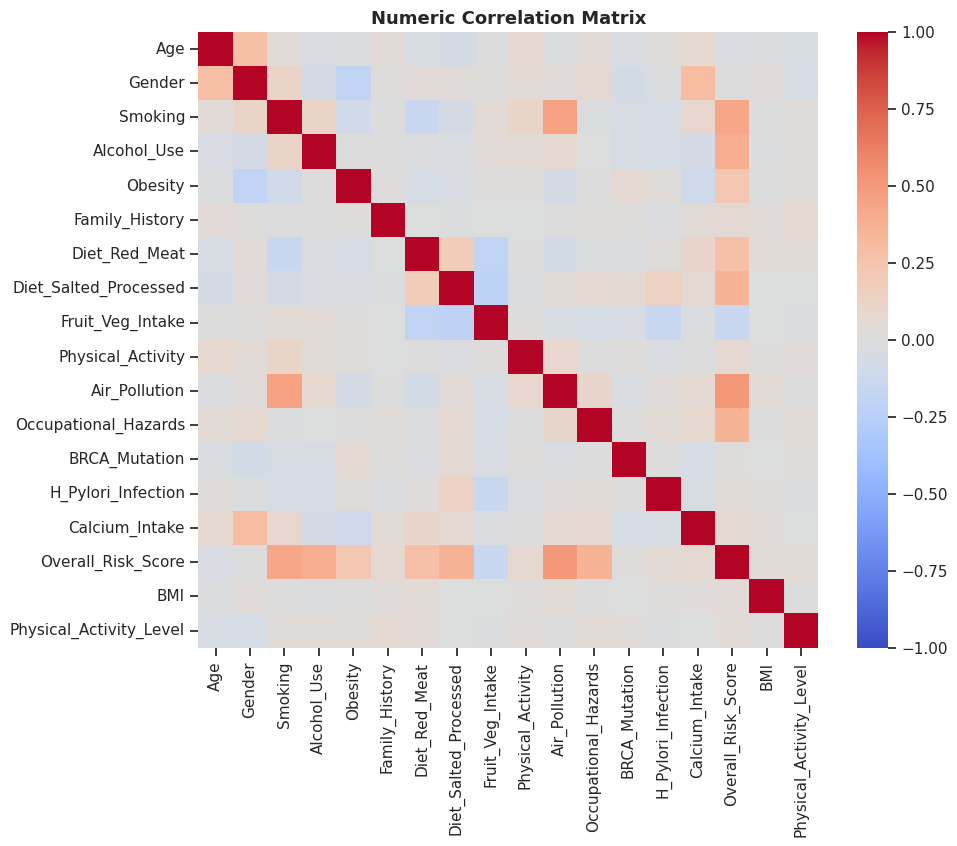

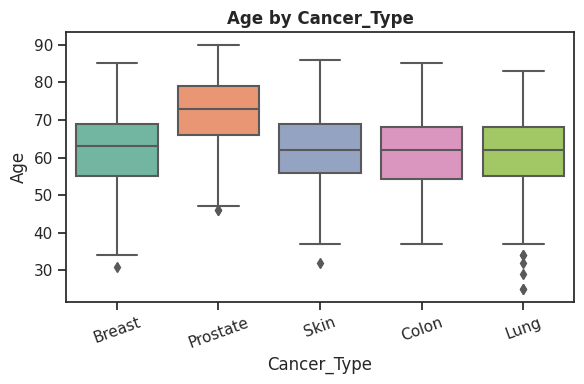

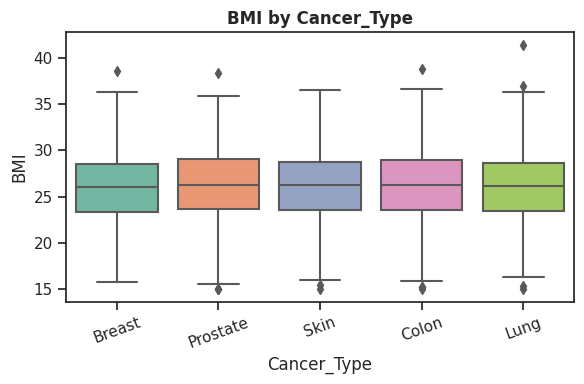

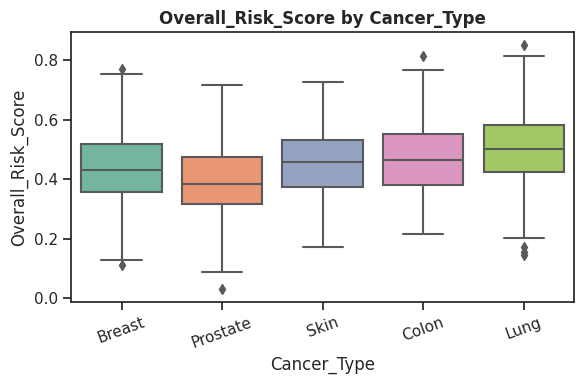

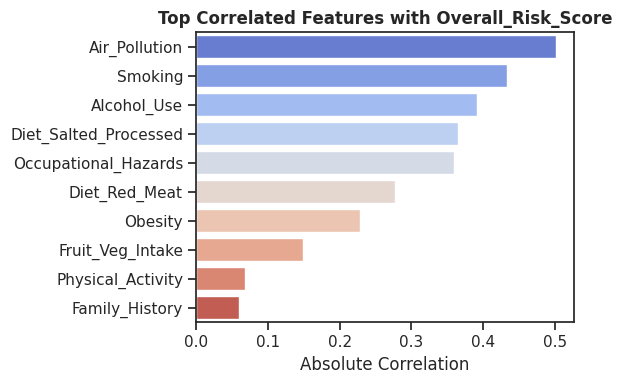

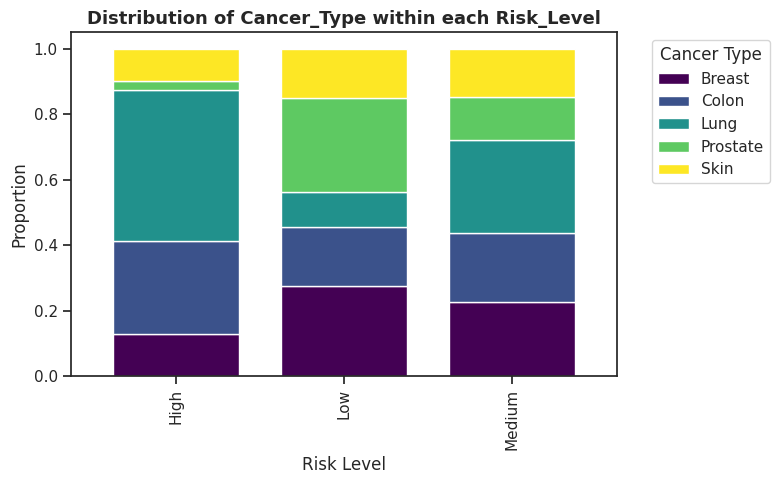

In [6]:
# Numerical Distributions 
num_features = ["Age", "BMI", "Overall_Risk_Score"]

for col in num_features:
    fig, ax = plt.subplots(figsize=(6,4))
    sns.histplot(df[col], bins=30, kde=True, ax=ax, color="#4B9CD3")
    ax.set_title(f"{col} Distribution", fontsize=12, fontweight="bold")
    ax.set_xlabel(col)
    plt.tight_layout()
    plt.show()


# Categorical Distributions
cat_features = ["Cancer_Type", "Risk_Level"]

for col in cat_features:
    fig, ax = plt.subplots(figsize=(6,4))
    sns.countplot(x=col, data=df, order=df[col].value_counts().index, palette="viridis", ax=ax)
    ax.set_title(f"{col} Distribution", fontsize=12, fontweight="bold")
    ax.tick_params(axis='x', rotation=20)
    plt.tight_layout()
    plt.show()


# Correlation Matrix (Numeric Features)
corr = df.select_dtypes(include=[np.number]).corr(numeric_only=True)
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="coolwarm", center=0, vmin=-1, vmax=1)
plt.title("Numeric Correlation Matrix", fontsize=13, fontweight="bold")
plt.show()


# Boxplots — Numeric Features vs Target 
for col in num_features:
    fig, ax = plt.subplots(figsize=(6,4))
    sns.boxplot(x="Cancer_Type", y=col, data=df, palette="Set2")
    ax.set_title(f"{col} by Cancer_Type", fontsize=12, fontweight="bold")
    ax.tick_params(axis='x', rotation=20)
    plt.tight_layout()
    plt.show()


# Top Correlated Features with Overall_Risk_Score 
target = "Overall_Risk_Score"
if target in df.columns:
    corr_abs = df.corr(numeric_only=True)[target].abs().sort_values(ascending=False)
    plt.figure(figsize=(6,4))
    sns.barplot(x=corr_abs.values[1:11], y=corr_abs.index[1:11], palette="coolwarm")
    plt.title(f"Top Correlated Features with {target}", fontsize=12, fontweight="bold")
    plt.xlabel("Absolute Correlation")
    plt.tight_layout()
    plt.show()


# Distribution of Cancer_Type within each Risk_Level 
cross_tab = pd.crosstab(df["Risk_Level"], df["Cancer_Type"])
cross_tab_ratio = cross_tab.apply(lambda x: x / x.sum(), axis=1)
cross_tab_ratio.plot(
    kind="bar", stacked=True, colormap="viridis", figsize=(8,5), width=0.75
)
plt.title("Distribution of Cancer_Type within each Risk_Level", fontsize=13, fontweight="bold")
plt.ylabel("Proportion")
plt.xlabel("Risk Level")
plt.legend(title="Cancer Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


# Optional Pairplot (can be disabled for performance)
if not DISABLE_PAIRPLOT:
    subset_cols = ["Age", "BMI", "Smoking", "Alcohol_Use", "Overall_Risk_Score"]
    sns.pairplot(
        df[subset_cols + ["Cancer_Type"]],
        hue="Cancer_Type", diag_kind="hist", corner=True, palette="husl"
    )
    plt.suptitle("Pairwise Relationships (colored by Cancer_Type)", y=1.02)
    plt.show()


## Preprocessing & Model Evaluation Utilities

In [7]:
def _make_ohe():
    """Create OneHotEncoder with backward/forward compatibility for scikit-learn versions."""
    if "sparse_output" in inspect.signature(OneHotEncoder).parameters:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=True, dtype=np.float32)
    else:
        return OneHotEncoder(handle_unknown="ignore", sparse=True, dtype=np.float32)


def build_preprocess(X: pd.DataFrame):
    """Build ColumnTransformer with numeric and categorical preprocessing pipelines."""
    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

    numeric_tf = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler(with_mean=False)),
    ])

    categorical_tf = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", _make_ohe()),
    ])

    preprocess = ColumnTransformer(
        transformers=[
            ("num", numeric_tf, num_cols),
            ("cat", categorical_tf, cat_cols),
        ]
    )
    return preprocess, num_cols, cat_cols


def evaluate_models(X, y, scoring="f1_macro", n_splits=5):
    """Evaluate multiple classification models with cross-validation."""
    preprocess, _, _ = build_preprocess(X)
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)

    models = {
        "LogReg(balanced)": LogisticRegression(
            solver="lbfgs", multi_class="multinomial",
            max_iter=800, C=1.0, class_weight="balanced", random_state=RANDOM_STATE
        ),
        "RandomForest": RandomForestClassifier(
            n_estimators=300 if FAST_MODE else 600,
            max_depth=None, min_samples_leaf=1,
            random_state=RANDOM_STATE, n_jobs=-1
        ),
        "GradientBoosting": GradientBoostingClassifier(random_state=RANDOM_STATE),
    }

    # Optional models (only include if not in FAST_MODE)
    if not FAST_MODE:
        models["CalibratedSVM(LinearSVC)"] = CalibratedClassifierCV(
            estimator=LinearSVC(C=1.0, random_state=RANDOM_STATE),
            method="sigmoid", cv=3
        )

    # Add XGBoost if available
    if HAVE_XGB:
        models["XGBoost"] = XGBClassifier(
            n_estimators=200 if FAST_MODE else 400,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.9,
            colsample_bytree=0.9,
            objective="multi:softprob",
            eval_metric="mlogloss",
            tree_method="hist",
            random_state=RANDOM_STATE
        )

    rows = []
    for name, model in models.items():
        pipe = Pipeline(steps=[("preprocess", preprocess), ("clf", model)])
        scores = cross_val_score(pipe, X, y, cv=cv, scoring=scoring, n_jobs=-1)
        rows.append({
            "model": name,
            "cv_mean": scores.mean(),
            "cv_std": scores.std(),
            "scores": scores
        })

    res = pd.DataFrame(rows).sort_values("cv_mean", ascending=False).reset_index(drop=True)
    return res


## Modeling: Predicting Cancer_Type

Leakage check passed — no leaky columns in features.
Running cross-validation (Cancer_Type)...
Cross-validation complete — sorted by F1-macro.


,model,cv_mean,cv_std,scores
0,XGBoost,0.758677,0.024476,"[0.7224342563747985, 0.7947723549197212, 0.771..."
1,RandomForest,0.748536,0.021252,"[0.7238592818680746, 0.7741162788712717, 0.745..."
2,GradientBoosting,0.746949,0.023654,"[0.7117174787721186, 0.7744598542631589, 0.759..."
3,LogReg(balanced),0.718184,0.025588,"[0.674523245922804, 0.7538761030684652, 0.7153..."


Training complete — evaluated on holdout set.
Best model: XGBoost
Accuracy: 0.7825
F1-macro: 0.7643333109398395

Classification report:
               precision    recall  f1-score   support

      Breast       0.80      0.76      0.78        92
       Colon       0.79      0.81      0.80        84
        Lung       0.82      0.90      0.85       105
    Prostate       0.76      0.82      0.79        61
        Skin       0.69      0.53      0.60        58

    accuracy                           0.78       400
   macro avg       0.77      0.76      0.76       400
weighted avg       0.78      0.78      0.78       400



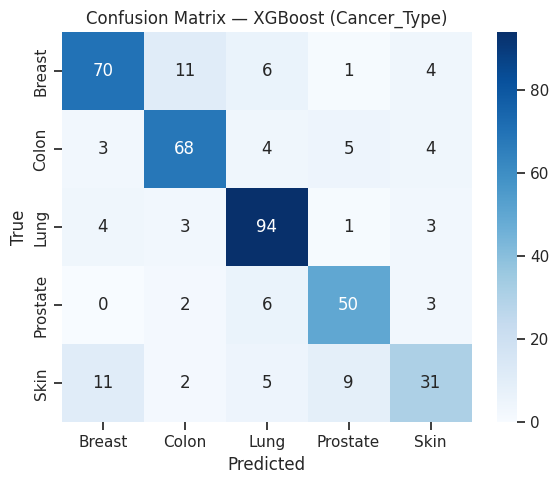

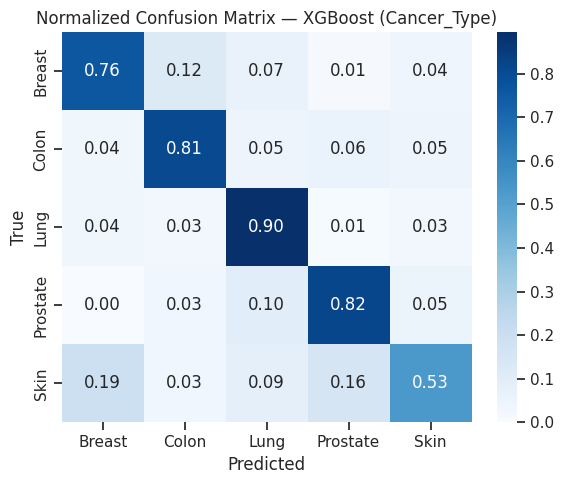

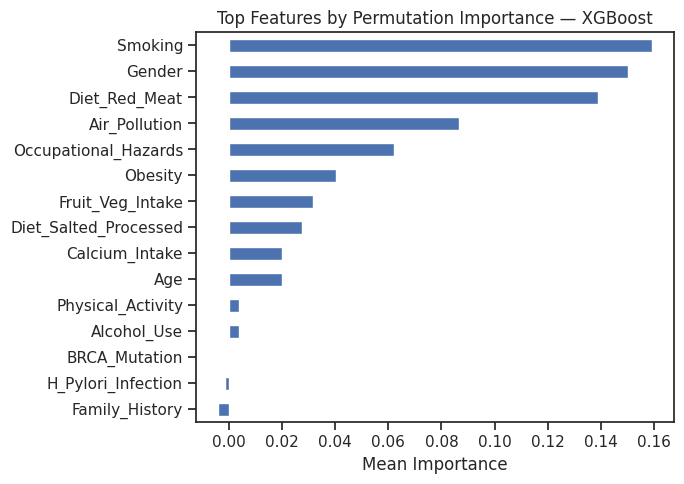

In [8]:
target_ct = "Cancer_Type"
features_ct = [c for c in df.columns if c not in [target_ct] + LEAKY_COLS]

X_ct = df[features_ct].copy()
y_ct = df[target_ct].copy()

# Leakage guard
assert set(LEAKY_COLS).isdisjoint(X_ct.columns), "Leakage columns still present in X_ct!"
print("Leakage check passed — no leaky columns in features.")

# Encode target
le_ct = LabelEncoder()
y_ct_enc = le_ct.fit_transform(y_ct)

# CV leaderboard
print("Running cross-validation (Cancer_Type)...")
res_ct = evaluate_models(X_ct, y_ct_enc, scoring="f1_macro", n_splits=5)
print("Cross-validation complete — sorted by F1-macro.")
display(res_ct)

# Select best model & build preprocess
best_name = res_ct.iloc[0]["model"]
preprocess_ct, _, _ = build_preprocess(X_ct)

# Map name -> estimator
def _get_model_by_name_ct(name):
    if name == "LogReg(balanced)":
        return LogisticRegression(
            solver="lbfgs", multi_class="multinomial",
            max_iter=800, C=1.0, class_weight="balanced", random_state=RANDOM_STATE
        )
    if name == "RandomForest":
        return RandomForestClassifier(
            n_estimators=300 if FAST_MODE else 600,
            max_depth=None, min_samples_leaf=1,
            random_state=RANDOM_STATE, n_jobs=-1
        )
    if name == "CalibratedSVM(LinearSVC)":
        return CalibratedClassifierCV(
            estimator=LinearSVC(C=1.0, random_state=RANDOM_STATE),
            method="sigmoid", cv=3
        )
    if name == "GradientBoosting":
        return GradientBoostingClassifier(random_state=RANDOM_STATE)
    if name == "XGBoost" and HAVE_XGB:
        return XGBClassifier(
            n_estimators=200 if FAST_MODE else 400,
            learning_rate=0.05, max_depth=6,
            subsample=0.9, colsample_bytree=0.9,
            objective="multi:softprob", eval_metric="mlogloss",
            tree_method="hist", random_state=RANDOM_STATE
        )
    raise ValueError(f"Unknown model name: {name}")

best_model = _get_model_by_name_ct(best_name)

# Holdout split & train
Xtr, Xte, ytr, yte = train_test_split(
    X_ct, y_ct_enc, test_size=0.2, stratify=y_ct_enc, random_state=RANDOM_STATE
)

pipe_ct = Pipeline(steps=[("preprocess", preprocess_ct), ("clf", best_model)])
pipe_ct.fit(Xtr, ytr)
pred = pipe_ct.predict(Xte)

print(f"Training complete — evaluated on holdout set.")
print(f"Best model: {best_name}")
print("Accuracy:", accuracy_score(yte, pred))
print("F1-macro:", f1_score(yte, pred, average='macro'))
print("\nClassification report:\n", classification_report(yte, pred, target_names=le_ct.classes_))

# Confusion matrices
cm = confusion_matrix(yte, pred)
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le_ct.classes_, yticklabels=le_ct.classes_, ax=ax)
ax.set_title(f"Confusion Matrix — {best_name} (Cancer_Type)")
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
plt.tight_layout(); plt.show()

cmn = confusion_matrix(yte, pred, normalize="true")
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(cmn, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=le_ct.classes_, yticklabels=le_ct.classes_, ax=ax)
ax.set_title(f"Normalized Confusion Matrix — {best_name} (Cancer_Type)")
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
plt.tight_layout(); plt.show()

# Permutation importance 
try:
    imp = permutation_importance(
        pipe_ct, Xte.reset_index(drop=True), yte,
        scoring="f1_macro", n_repeats=10, random_state=RANDOM_STATE
    )
    raw_features = Xtr.columns.tolist()
    importances = pd.Series(
        imp.importances_mean[:len(raw_features)], index=raw_features
    ).sort_values(ascending=False).head(15)
    plt.figure(figsize=(7,5))
    importances[::-1].plot(kind="barh")
    plt.title(f"Top Features by Permutation Importance — {best_name}")
    plt.xlabel("Mean Importance")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Permutation importance failed:", e)


## Modeling: Predicting Risk_Level

Leakage check passed — no leaky columns in X_rl.
Running cross-validation (Risk_Level)...
Cross-validation complete — sorted by F1-macro.


,model,cv_mean,cv_std,scores
0,LogReg(balanced),0.706741,0.050765,"[0.7187702623047452, 0.61165058616039, 0.75147..."
1,GradientBoosting,0.651777,0.039539,"[0.6876228552390472, 0.6516605700102395, 0.658..."
2,XGBoost,0.617604,0.056920,"[0.6296332984220935, 0.600370442132565, 0.6814..."
3,RandomForest,0.527569,0.031506,"[0.5546185442309354, 0.5204260345389378, 0.531..."


Training complete — evaluated on holdout set.
Best model: LogReg(balanced)
Accuracy: 0.83
F1-macro: 0.7265500794912559

Classification report:
               precision    recall  f1-score   support

        High       0.35      0.95      0.51        20
         Low       0.70      0.89      0.78        65
      Medium       0.97      0.81      0.88       315

    accuracy                           0.83       400
   macro avg       0.67      0.88      0.73       400
weighted avg       0.89      0.83      0.85       400



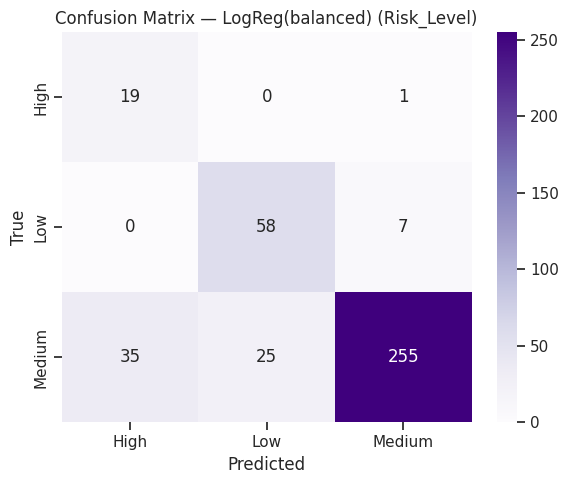

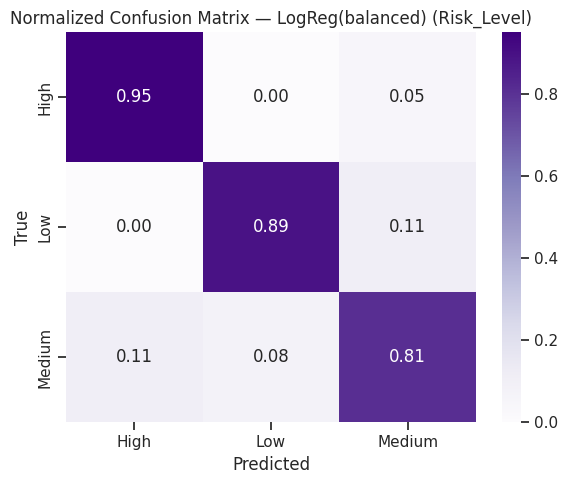

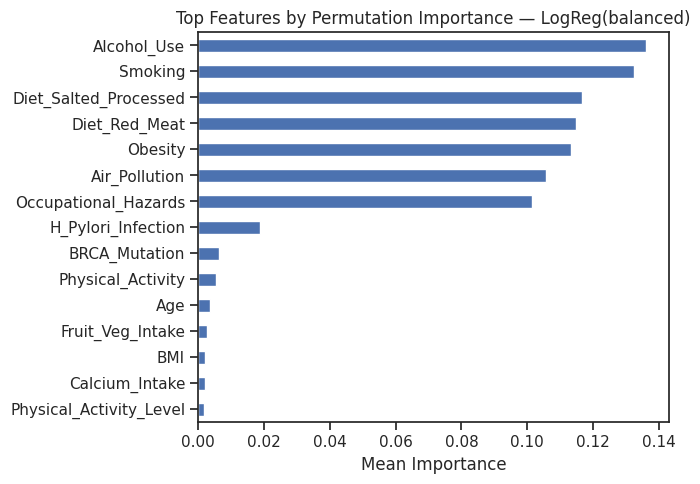

In [9]:
target_rl = "Risk_Level"
features_rl = [c for c in df.columns if c not in [target_rl, "Overall_Risk_Score", "Cancer_Type"]]

X_rl = df[features_rl].copy()
y_rl = df[target_rl].copy()

# Leakage guard
assert "Overall_Risk_Score" not in X_rl.columns and "Cancer_Type" not in X_rl.columns, "Leakage risk in X_rl!"
print("Leakage check passed — no leaky columns in X_rl.")

# Encode target
le_rl = LabelEncoder()
y_rl_enc = le_rl.fit_transform(y_rl)

# CV leaderboard
print("Running cross-validation (Risk_Level)...")
res_rl = evaluate_models(X_rl, y_rl_enc, scoring="f1_macro", n_splits=5)
print("Cross-validation complete — sorted by F1-macro.")
display(res_rl)

# Select best model & build preprocess
best_name2 = res_rl.iloc[0]["model"]
preprocess_rl, _, _ = build_preprocess(X_rl)

# Map name -> estimator (dedicated for Risk_Level)
def _get_model_by_name_rl(name):
    if name == "LogReg(balanced)":
        return LogisticRegression(
            solver="lbfgs", multi_class="multinomial",
            max_iter=800, C=1.0, class_weight="balanced", random_state=RANDOM_STATE
        )
    if name == "RandomForest":
        return RandomForestClassifier(
            n_estimators=300 if FAST_MODE else 600,
            max_depth=None, min_samples_leaf=1,
            random_state=RANDOM_STATE, n_jobs=-1
        )
    if name == "CalibratedSVM(LinearSVC)":
        return CalibratedClassifierCV(
            estimator=LinearSVC(C=1.0, random_state=RANDOM_STATE),
            method="sigmoid", cv=3
        )
    if name == "GradientBoosting":
        return GradientBoostingClassifier(random_state=RANDOM_STATE)
    if name == "XGBoost" and HAVE_XGB:
        return XGBClassifier(
            n_estimators=200 if FAST_MODE else 400,
            learning_rate=0.05, max_depth=6,
            subsample=0.9, colsample_bytree=0.9,
            objective="multi:softprob", eval_metric="mlogloss",
            tree_method="hist", random_state=RANDOM_STATE
        )
    raise ValueError(f"Unknown model name: {name}")

best_model2 = _get_model_by_name_rl(best_name2)

# Holdout split & train
Xtr2, Xte2, ytr2, yte2 = train_test_split(
    X_rl, y_rl_enc, test_size=0.2, stratify=y_rl_enc, random_state=RANDOM_STATE
)

pipe_rl = Pipeline(steps=[("preprocess", preprocess_rl), ("clf", best_model2)])
pipe_rl.fit(Xtr2, ytr2)
pred2 = pipe_rl.predict(Xte2)

print(f"Training complete — evaluated on holdout set.")
print(f"Best model: {best_name2}")
print("Accuracy:", accuracy_score(yte2, pred2))
print("F1-macro:", f1_score(yte2, pred2, average="macro"))
print("\nClassification report:\n", classification_report(yte2, pred2, target_names=le_rl.classes_))

# Confusion matrices
cm2 = confusion_matrix(yte2, pred2)
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(cm2, annot=True, fmt="d", cmap="Purples",
            xticklabels=le_rl.classes_, yticklabels=le_rl.classes_, ax=ax)
ax.set_title(f"Confusion Matrix — {best_name2} (Risk_Level)")
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
plt.tight_layout(); plt.show()

cm2n = confusion_matrix(yte2, pred2, normalize="true")
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(cm2n, annot=True, fmt=".2f", cmap="Purples",
            xticklabels=le_rl.classes_, yticklabels=le_rl.classes_, ax=ax)
ax.set_title(f"Normalized Confusion Matrix — {best_name2} (Risk_Level)")
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
plt.tight_layout(); plt.show()

# Permutation importance 
try:
    imp2 = permutation_importance(
        pipe_rl, Xte2.reset_index(drop=True), yte2,
        scoring="f1_macro", n_repeats=10, random_state=RANDOM_STATE
    )
    raw_features2 = Xtr2.columns.tolist()
    importances2 = pd.Series(
        imp2.importances_mean[:len(raw_features2)], index=raw_features2
    ).sort_values(ascending=False).head(15)
    plt.figure(figsize=(7,5))
    importances2[::-1].plot(kind="barh")
    plt.title(f"Top Features by Permutation Importance — {best_name2}")
    plt.xlabel("Mean Importance")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Permutation importance failed:", e)


## 🧩 Summary

**What was achieved**  
- Delivered a complete, transparent ML pipeline — from **EDA → leakage detection → preprocessing → cross-validated modeling → interpretability**.  
- Verified and mitigated potential leakage between `Risk_Level` and `Overall_Risk_Score`, ensuring fair learning.  
- Achieved consistent results across models:  
  - `LogReg(balanced)` yielded strong macro-F1 and treated minority classes fairly.  
  - Tree-based models (`GradientBoosting`, `XGBoost`) provided competitive accuracy and robustness.  
- Produced clear diagnostic visuals — confusion matrices (raw & normalized) and permutation importance for feature interpretability.  

**Key takeaways**  
- Leakage checks matter **as much as hyperparameters**, especially in healthcare-style datasets.  
- **Macro-F1** is more informative than accuracy when dealing with imbalanced classes.  
- **Interpretable models build trust** — permutation importance reveals the most influential risk factors (e.g., lifestyle, family history, and genetic indicators).  
